# SVM Implementation

## Libraries

In [ ]:
import os
import cv2
import random
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Loading Data

In [2]:
data_file = "C:/Users/afrod/Documents/Neural_Networks/MergedDataset"
classes = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]
training_data = []


def create_training_data():
    for dementia_level in classes:
        path = os.path.join(data_file, dementia_level)
        class_num = classes.index(dementia_level)
        for img in os.listdir(path):
            # Convert to grayscale for smaller array dimensions
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            final_array = cv2.resize(img_array, (100,95))
            training_data.append([final_array, class_num])

create_training_data()

## Preprocessing and Loading

In [3]:
random.shuffle(training_data)

# Separating features and labels
# Images are also flattened to be used as input in the knn algorithm
X = np.array([features for features, _ in training_data]).reshape(-1, 100*95)
y = np.array([label for _, label in training_data])

# Rescaling
X = (X-X.min())/(X.max() - X.min())

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(X_train.shape[0])

24230


## Simple Model

In [8]:
# Hyperparameters
degree = 5
kernel = 'poly'
C = 10
gamma = 'scale'

# Create an SVM model
svm = SVC(degree=degree, kernel=kernel, C=C, gamma=gamma, random_state=42)

# Train the model
svm.fit(X_train, y_train)

SVC(C=10, degree=5, kernel='poly', random_state=42)

## Implementing cross-validation for hyperparameter tuning

In [4]:
# Define parameter grid
param_grid = {
    'C': [100, 1000],          
    'gamma': ['scale'], 
    'kernel': ['rbf', 'poly'],
    'degree' : [4]
}

In [ ]:
# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=3, 
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

In [6]:
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [100, 1000], 'degree': [4], 'gamma': ['scale'],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=2)

In [7]:
# Display best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'C': 100, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8347090383821709


## Visualizing decision boundary

In [11]:
# Step 1: Reduce data to 2D using t-SNE
def reduce_to_2d_tsne(X):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
    return tsne.fit_transform(X)

# Step 2: Plot decision boundaries
def plot_decision_boundaries(X, y, model, title="SVM Decision Boundary"):
    # Create a mesh grid for plotting
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Predict on each point in the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

    # Plot original samples
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor='k')
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

In [ ]:
# Reduce to 2D using t-SNE
X_train_2d = reduce_to_2d_tsne(X_train)
X_test_2d = reduce_to_2d_tsne(X_test)

In [ ]:
# Hyperparameters
degree = 5
kernel = 'poly'
C = 100
gamma = 0.1

# Create an SVM model
svm = SVC(degree=degree, kernel=kernel, C=C, gamma=gamma, random_state=42)

# Train the model
svm.fit(X_train_2d, y_train)

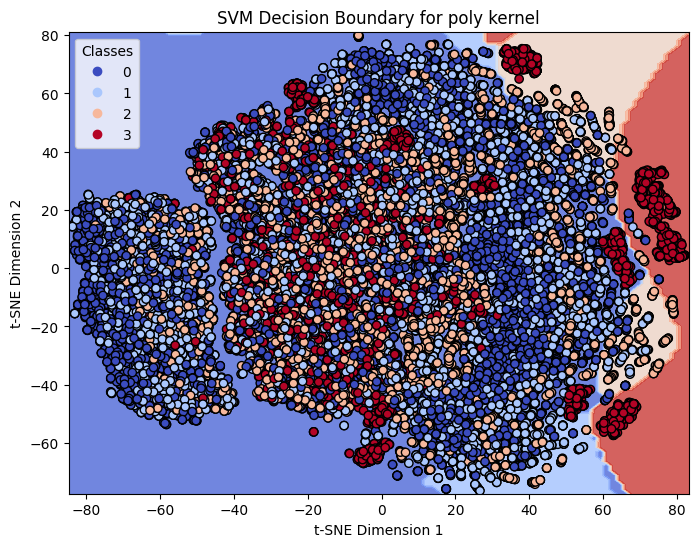

In [15]:
# Plot decision boundary
plot_decision_boundaries(X_train_2d, y_train, svm, title="SVM Decision Boundary for poly kernel")

## Evaluation of model

This evaluation code is used for all different experimentations. Only run one model at a time before evaluating and change inputs accordingly

### Evaluating on Test

In [ ]:
y_pred = svm.predict(X_test_2d)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nSVM with hyperparameters: kernel={kernel}, degree={degree}, C={C}, gamma={gamma}")
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


SVM with hyperparameters: kernel=poly, degree=5, C=100, gamma=scale
Test Accuracy: 26.41%
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.80      0.43      5163
           1       0.15      0.01      0.01      4437
           2       0.11      0.03      0.04      3931
           3       0.01      0.00      0.00      2623

    accuracy                           0.26     16154
   macro avg       0.14      0.21      0.12     16154
weighted avg       0.16      0.26      0.15     16154

Confusion Matrix:
 [[4126    7  369  661]
 [3915   32  241  249]
 [3728   49  104   50]
 [2303  120  195    5]]


### Evaluating on Train

In [ ]:
y_pred = svm.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"\nSVM with hyperparameters: kernel={kernel}, degree={degree}, C={C}, gamma={gamma}")
print(f'Train Accuracy: {accuracy * 100:.2f}%')
print("Classification Report:\n", classification_report(y_train, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred))


SVM with hyperparameters: kernel=poly, degree=5, C=10, gamma=scale
Train Accuracy: 99.35%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      7637
           1       0.99      1.00      0.99      6763
           2       0.99      1.00      0.99      5925
           3       1.00      0.99      1.00      3905

    accuracy                           0.99     24230
   macro avg       0.99      0.99      0.99     24230
weighted avg       0.99      0.99      0.99     24230

Confusion Matrix:
 [[7524   76   37    0]
 [   0 6760    3    0]
 [   0    4 5921    0]
 [   0   20   17 3868]]
